### NOx prediction given fuel consumption

In [2]:
import os
from pathlib import Path
import pickle
import warnings

import numpy as np

from scipy.spatial.distance import euclidean
from scipy.signal import correlate

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pdb


from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

In [4]:
import pandas as pd
from pandas import concat
from pandas import DataFrame
import numpy as np
import scipy.ndimage as ndi
import random

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

In [6]:
import pickle
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint
from skorch.helper import predefined_split

from typing import Iterable

In [7]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.cuda.set_device(0)
torch.manual_seed(20201130)
torch.cuda.manual_seed(20201130)

### Read data

In [8]:
# Read npy files (각각의 분리된 기동)
folder_path = os.path.join('output')
npy_files = [file for file in os.listdir(folder_path) if file.endswith('.npy')]
all_data = [np.load(os.path.join(folder_path, file), allow_pickle=True) for file in npy_files]

print(f"Number of all data: {len(all_data)}")
print(f"Shape of 10th data: {all_data[10].shape}")

Number of all data: 113
Shape of 10th data: (13455, 25)


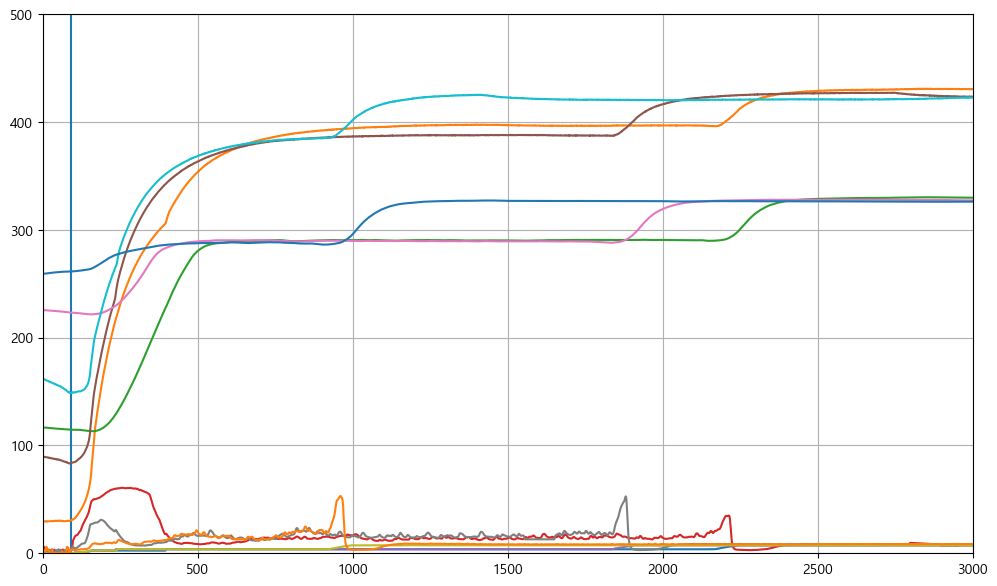

In [11]:
plt.figure(figsize=(12,7))
plt.grid()
plt.ylim(0,500)
plt.xlim(0,3000)

def feat_plot(inp, didx, fidx, st, et):
    plt.plot(inp[didx][st:et,fidx])

def my_plot(adata, indx, feats=[2,3,7,16,19]):
    for fi in indx:
        for ii in feats:
            feat_plot(adata, fi, ii, 0,6000)
        
plt.axvline(x=90)        
my_plot(all_data, [0,1,2], feats=[2,7,19,23])

#### Extract training data

In [12]:
def crop_series(cut_data, front_cut=2500):
    dfeat = cut_data[0].shape[1]
    dtrain, dlabel = [], []
    indx = [2,3,7,8,9,10,11,16,18,19,23,24]

    for data in cut_data:
        # cut previous part front_cut tics
        dlen = min(data.shape[0], front_cut)
        for vv in range(50,dlen-50):
            dinp = data[vv-32:vv, indx]
            dout = data[vv:vv+16, indx]
            dtrain.append(dinp)
            dlabel.append(dout)

    dtrain = np.array(dtrain, dtype=np.float32)
    dlabel = np.array(dlabel, dtype=np.float32)    
    
    return dtrain, dlabel



train_ox, train_oy = crop_series(all_data[:100])
valid_ox, valid_oy = crop_series(all_data[100:])
train_ox.shape, train_oy.shape, valid_ox.shape, valid_oy.shape

((240000, 32, 12), (240000, 16, 12), (31200, 32, 12), (31200, 16, 12))

#### Normalization

In [13]:
def my_normalize(train_x, train_y, valid_x, valid_y):
    maximum = np.ones(train_x.shape[2])
    minimum = np.ones(train_x.shape[2])
    
    for v in range(train_x.shape[2]):
        maximum[v] = np.max(train_x[:,:,v])
        minimum[v] = np.min(train_x[:,:,v])            

        denom = maximum[v]-minimum[v]
        train_x[:,:,v] = np.clip((train_x[:,:,v]-minimum[v]) / denom, 0.0, 1.0)
        train_y[:,:,v] = np.clip((train_y[:,:,v]-minimum[v]) / denom, 0.0, 1.0)
        valid_x[:,:,v] = np.clip((valid_x[:,:,v]-minimum[v]) / denom, 0.0, 1.0)
        valid_y[:,:,v] = np.clip((valid_y[:,:,v]-minimum[v]) / denom, 0.0, 1.0)
    
    print(maximum, minimum)
    return train_x, train_y, valid_x, valid_y


train_x, train_yo, valid_x, valid_yo = my_normalize(train_ox, train_oy, valid_ox, valid_oy)

[   9.92175198   31.71004105  474.6824646  1093.38330078  200.
   21.57629967  108.87136078  178.75488281  654.4331665   341.40530396
  171.56300354   10.        ] [ 0.00000000e+00 -1.10027657e+01  2.30062408e+01 -5.12715578e-01
  0.00000000e+00  4.21034405e-03  0.00000000e+00 -5.39944458e+00
  2.18701439e+01  1.13262741e+02  0.00000000e+00  0.00000000e+00]


In [14]:
def model_data(data_x, data_y):
    x0 = []
    x1 = []
    y0 = []
    indx = [0,1,2,3,4,5,6,7,8,9,10]
    indy = [1,2,3,4,5,6,7,8,9,10]
    for x,y in zip(data_x,data_y):   
        x0.append(x[:,indx])  
        x1.append(y[0,0:1])
        y0.append(y[0,indy])

    x0 = np.array(x0, dtype=np.float32)
    x1 = np.array(x1, dtype=np.float32)
    y0 = np.array(y0, dtype=np.float32)
    return x0, x1, y0


train_x1, train_x2, train_y = model_data(train_x, train_yo)
valid_x1, valid_x2, valid_y = model_data(valid_x, valid_yo)
train_x1.shape, train_x2.shape, train_y.shape, valid_x1.shape, valid_x2.shape, valid_y.shape

((240000, 32, 11),
 (240000, 1),
 (240000, 10),
 (31200, 32, 11),
 (31200, 1),
 (31200, 10))

#### Skorch: train, valid split training with multiple inpus

In [16]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, x1, x2, y):
        self.x1 = x1
        self.x2 = x2
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {'x1': self.x1[idx], 'x2': self.x2[idx]}, self.y[idx]

    
valid_dataset = CustomDataset(valid_x1, valid_x2, valid_y)
train_dict = {'x1': train_x1, 'x2': train_x2}

### Model

In [17]:
class NOxPred(nn.Module):
    def __init__(self, tlen=32):
        super(NOxPred, self).__init__()
        self.gru1 = nn.GRU(11,64,1,batch_first=True)
        self.fc1 = nn.Linear(2048,512)  # 2048=64*32   
        self.fc2 = nn.Linear(512,128)   
        self.fc3 = nn.Linear(256,10)
        self.fc_given = nn.Linear(1,128)
        
    def forward(self, x1, x2):
        r1 = torch.randn(1,x1.shape[0], 64).cuda()  # (1,b,64)
        t1, _ = self.gru1(x1, r1)  # (b,32,64)
        g1 = self.fc_given(x2)

        o1 = self.fc1(t1.reshape(t1.shape[0],-1))  # (b,2048)->(b,512)
        o2 = self.fc2(F.softplus(o1))
        c1 = torch.concat((g1,o2), dim=1)  
        o3 = self.fc3(F.softplus(c1))
        return o3  
    
    
model = NOxPred()

In [18]:
regressor = NeuralNetRegressor(
    model,
    max_epochs=10000,  # 50
    lr=0.0001,
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=True,
    batch_size=2048,
    train_split=predefined_split(valid_dataset),
    callbacks=[Checkpoint(f_params='best_params.pt')],
    device = 'cuda'  # 'cpu'
)

In [19]:
regressor.fit(train_dict, train_y) 
#regressor.fit(train_dataset, y=None) 

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0628        0.0157     +  4.7506


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=NOxPred(
    (gru1): GRU(11, 64, batch_first=True)
    (fc1): Linear(in_features=2048, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=128, bias=True)
    (fc3): Linear(in_features=256, out_features=10, bias=True)
    (fc_given): Linear(in_features=1, out_features=128, bias=True)
  ),
)

In [143]:
regressor.load_params(f_params='best_params.pt')

In [21]:
crop_num = 0
crop_len = 2400

st, et = crop_num*crop_len, (crop_num+1)*crop_len
valid_dict = {'x1': valid_x1[st:et], 'x2': valid_x2[st:et]}
res = regressor.predict(valid_dict)  # crop_len=연속1개 데이터 길이
res.shape

(2400, 10)

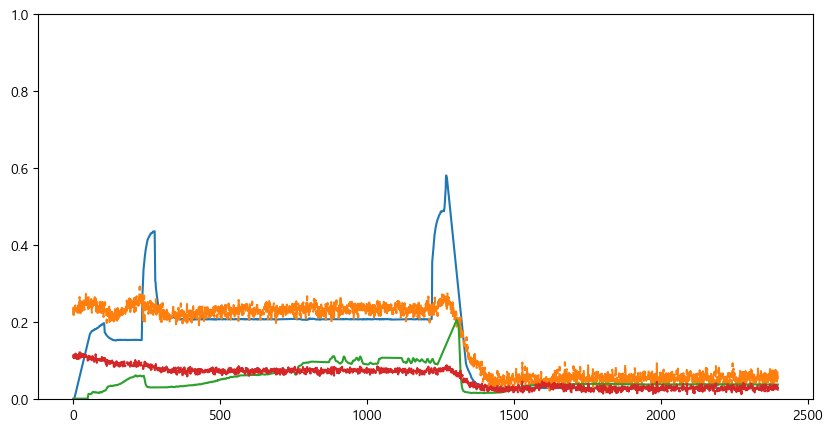

In [24]:
plt.figure(figsize=(10,5))
plt.ylim(0,1)

plt.plot(valid_y[st:et,2])  # nh3
plt.plot(res[:,2],'--')
plt.plot(valid_y[st:et,9])  # nox
plt.plot(res[:,9],'--')

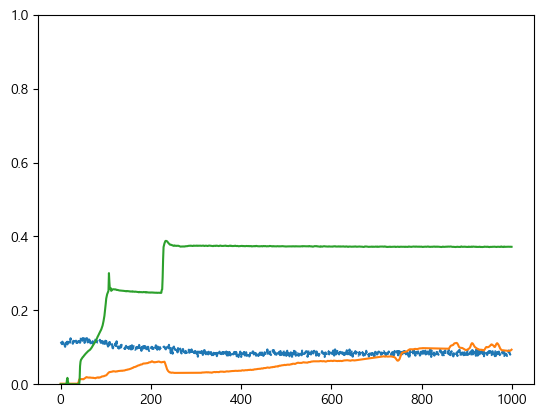

In [25]:
st = 10
valid_dict = {'x1': valid_x1[st:st+1], 'x2': valid_x2[st:st+1]}

plt.ylim(0,1)

pred_y = []
for ii in range(st+1,st+1000):
    res = regressor.predict(valid_dict)
    pred_y.append(res[0,9])
    aa=np.concatenate((valid_dict['x2'],res),1)  # (1,11)
    #pdb.set_trace()
    bb=np.concatenate((valid_dict['x1'][0,1:,:],aa),0)  # (32,11)
    cc=np.expand_dims(bb,0)  # (1,32,11)
    valid_dict = {'x1': cc, 'x2': valid_x2[ii:ii+1]}
    
    
plt.plot(pred_y,'--')
plt.plot(valid_y[st:st+1000,9])
plt.plot(valid_x2[st:st+1000,0])